In [1]:
import pandas as pd
import time
import numpy as np
import struct
import matplotlib.pyplot as plt
from cr_data_inspection_functions import *
from lwa_antpos import mapping
from scipy.optimize import curve_fit
import scipy.stats as st
import math


Read antpos from xlsx file in repo


In [58]:
#datadir='/data1/cosmic-ray-data/2023July1/'+'overnight16882'
#dataproductsdir='/data1/cosmic-ray-data/2023July1-data-products/'

datadir='/data0/cosmic-ray-data/2023July4/'+'overnight16885'
dataproductsdir='/data0/cosmic-ray-data/2023July4-data-products/'

In [59]:
#summary_filename='/data0/cosmic-ray-data/2023May3-dataproducts/summary.txt'
summary_filename0='/data0/cosmic-ray-data/2023June20-data-products/summary.txt'
summary_filename1='/data1/cosmic-ray-data/2023June20-data-products/summary.txt'
summary_filename='/data1/cosmic-ray-data/2023July1-data-products/summary.txt'
summary_filename='/data0/cosmic-ray-data/2023July4-data-products/summary.txt'

summary_filenames=[summary_filename]

colnames=['fname',
          'config_file',
          'total_event_count',
          'complete_events_count',
          'incomplete_events_count',
          'scrambled_complete_events',
          'pass_rms_change_cut',
          'pass_veto_cut',
          'pass_max_distant_vs_core_cut',
          'pass_top5_distant_vs_core_cut',
          'pass_distant_vs_core_cut2',
          'total_selected_v1',
          'total_selected_v2']

all_lines=[]
for summary_filename in summary_filenames:
    with open(summary_filename) as file:
        lines = [line.rstrip().split() for line in file if (line[:2]!='St' and line[:2]!='Re')]
    all_lines+=lines
    
summary = pd.DataFrame(columns=colnames,index=range(len(all_lines)))



In [60]:
print(len(lines))
print(len(all_lines))

568
568


In [61]:
for j,line in enumerate(all_lines):
    for i in range(len(line)):
        if i>1: #the first two are strings
            line[i]=int(line[i])
    summary.loc[j]=line
            


In [63]:
valid_files=summary['complete_events_count']>0
invalid_files=summary['complete_events_count']==0
print(invalid_files.sum())

1


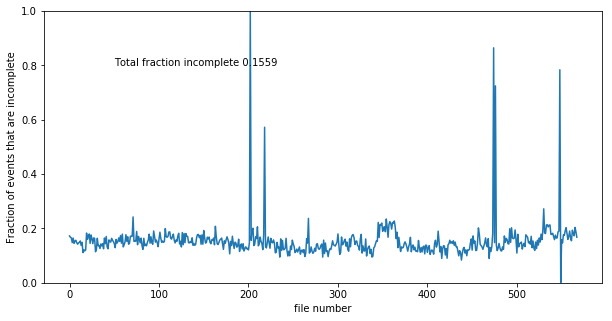

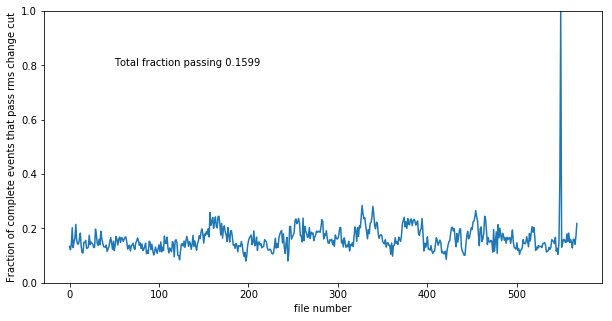

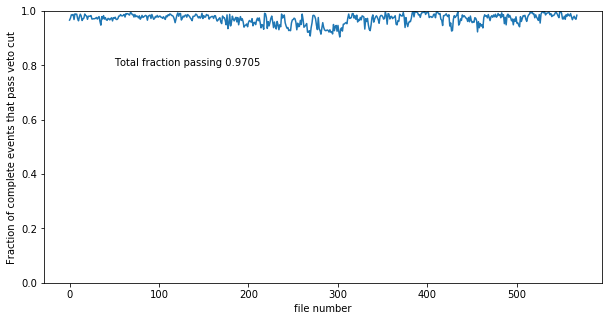

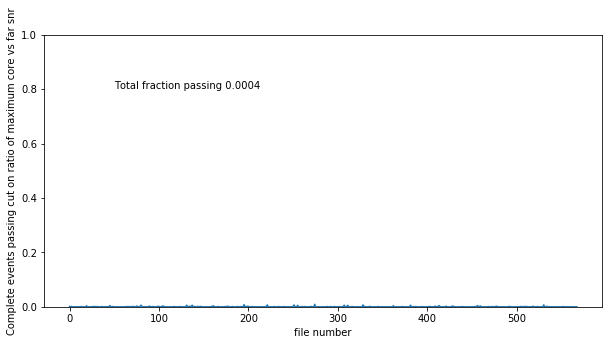

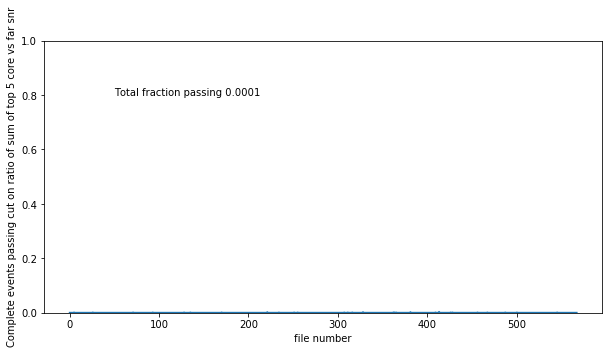

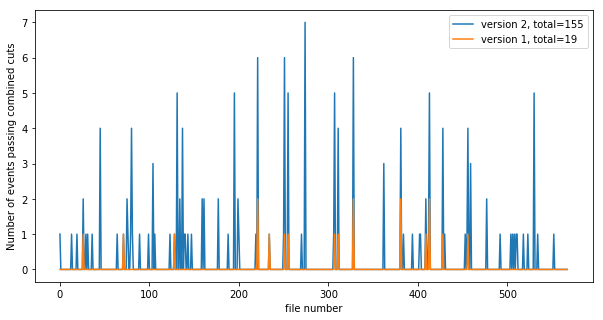

In [64]:
plt.figure(figsize=(10,5))
plt.xlabel('file number')
plt.ylabel('Fraction of events that are incomplete')
plt.plot(summary['incomplete_events_count']/summary['total_event_count'])
plt.ylim(0,1)
total=summary['incomplete_events_count'].sum()/summary['total_event_count'].sum()
plt.text(50,0.8,'Total fraction incomplete '+str(round(total,4)))

plt.figure(figsize=(10,5))
plt.xlabel('file number')
plt.ylabel('Fraction of complete events that pass rms change cut')
plt.plot(summary['pass_rms_change_cut'][valid_files]/summary['complete_events_count'][valid_files])
plt.ylim(0,1)
total=(summary['pass_rms_change_cut'][valid_files]).sum()/(summary['complete_events_count'][valid_files]).sum()
plt.text(50,0.8,'Total fraction passing '+str(round(total,4)))

plt.figure(figsize=(10,5))
plt.xlabel('file number')
plt.ylabel('Fraction of complete events that pass veto cut')
plt.plot((summary['pass_veto_cut'][valid_files])/(summary['complete_events_count'][valid_files]))
total=(summary['pass_veto_cut'][valid_files]).sum()/(summary['complete_events_count'][valid_files]).sum()
plt.text(50,0.8,'Total fraction passing '+str(round(total,4)))
plt.ylim(0,1)

plt.figure(figsize=(10,5))
plt.xlabel('file number')
plt.ylabel('Complete events passing cut on ratio of maximum core vs far snr')
plt.plot((summary['pass_max_distant_vs_core_cut'][valid_files])/(summary['complete_events_count'][valid_files]))
total=(summary['pass_max_distant_vs_core_cut'][valid_files]).sum()/(summary['complete_events_count'][valid_files]).sum()
plt.text(50,0.8,'Total fraction passing '+str(round(total,4)))

plt.ylim(0,1)

plt.figure(figsize=(10,5))
plt.xlabel('file number')
plt.ylabel('Complete events passing cut on ratio of sum of top 5 core vs far snr')
plt.plot((summary['pass_top5_distant_vs_core_cut'][valid_files])/(summary['complete_events_count'][valid_files]))
total=(summary['pass_top5_distant_vs_core_cut'][valid_files]).sum()/(summary['complete_events_count'][valid_files]).sum()
plt.text(50,0.8,'Total fraction passing '+str(round(total,4)))
plt.ylim(0,1)

plt.figure(figsize=(10,5))
plt.xlabel('file number')
plt.ylabel('Number of events passing combined cuts')
plt.plot(summary['total_selected_v2'],label='version 2, total='+str(summary['total_selected_v2'].sum()))
plt.plot(summary['total_selected_v1'],label='version 1, total='+str(summary['total_selected_v1'].sum()))
plt.legend()


In [65]:
print(summary.columns)

Index(['fname', 'config_file', 'total_event_count', 'complete_events_count',
       'incomplete_events_count', 'scrambled_complete_events',
       'pass_rms_change_cut', 'pass_veto_cut', 'pass_max_distant_vs_core_cut',
       'pass_top5_distant_vs_core_cut', 'pass_distant_vs_core_cut2',
       'total_selected_v1', 'total_selected_v2'],
      dtype='object')


In [66]:
for name in summary.columns:
    if (name!='fname' and name!='config_file'):
        print(name,summary[name].sum())
print(summary['total_selected_v1'].sum()/summary['complete_events_count'].sum())
print(summary['total_selected_v2'].sum()/summary['complete_events_count'].sum())

total_event_count 573093
complete_events_count 483775
incomplete_events_count 89318
scrambled_complete_events 0
pass_rms_change_cut 77369
pass_veto_cut 469491
pass_max_distant_vs_core_cut 215
pass_top5_distant_vs_core_cut 33
pass_distant_vs_core_cut2 234
total_selected_v1 19
total_selected_v2 155
3.927445610045992e-05
0.00032039687871427834


## Examine events that passed 


In [67]:
files_with_interesting_events=[]
for i in range(len(summary)):
    if (summary['total_selected_v1'][i]):
        print(summary['fname'][i],summary['total_selected_v1'][i],summary['total_selected_v2'][i])
        files_with_interesting_events.append(summary['fname'][i])
        

38006.5317307.dat 1 2
38484.4078517.dat 1 1
39156.1595051.dat 1 1
40176.2966914.dat 2 6
40335.872607.dat 1 1
40558.9189126.dat 1 6
40612.3937843.dat 1 5
41259.2644067.dat 1 5
41308.5729182.dat 1 4
41554.371115.dat 2 6
42255.2693527.dat 2 4
42649.8479218.dat 1 2
42719.2721612.dat 2 5
42949.0702407.dat 1 4
43379.965755.dat 1 4


0 41554.371115.dat


/home/ubuntu/anaconda3/envs/deployment/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/deployment/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


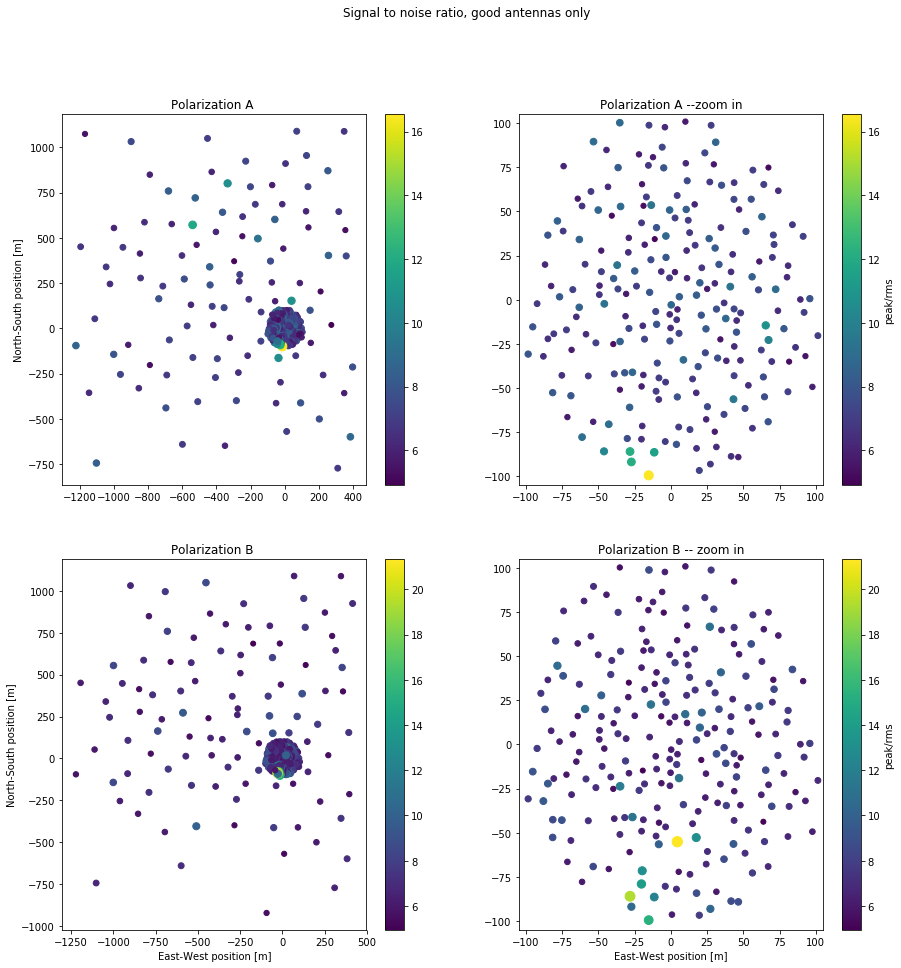

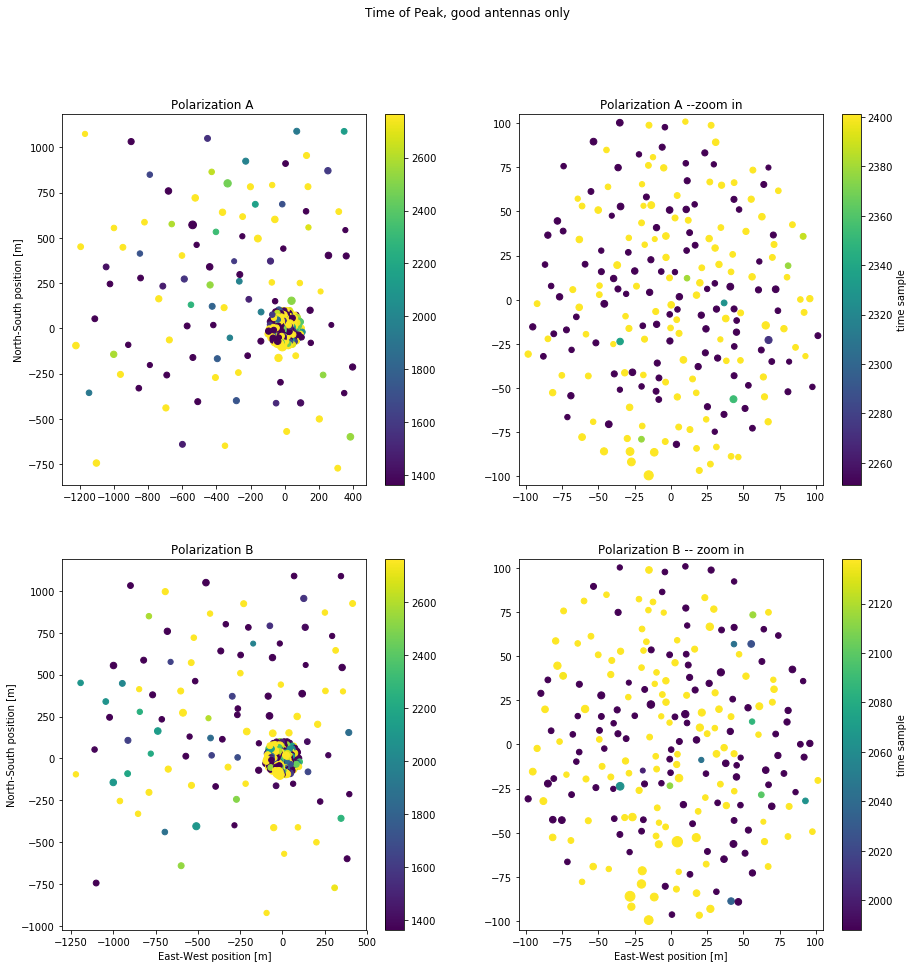

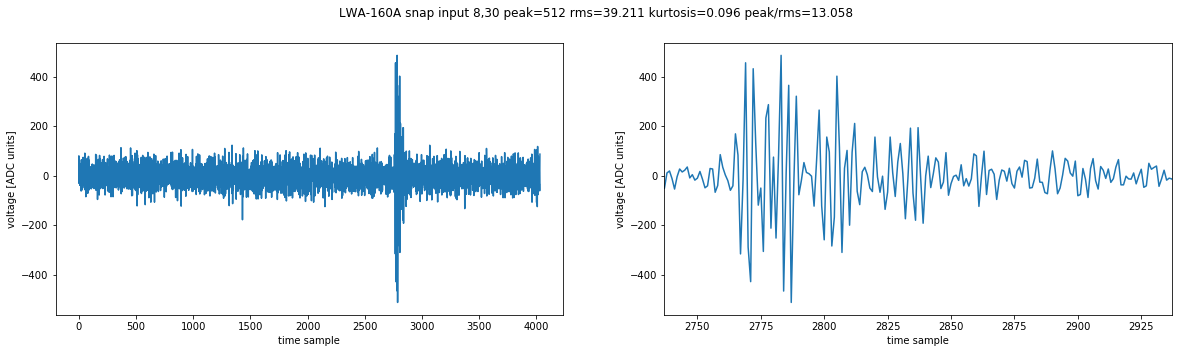

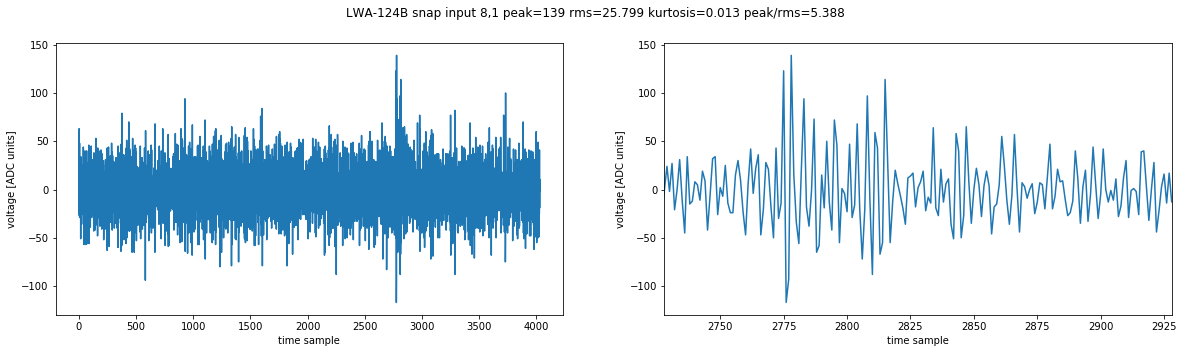

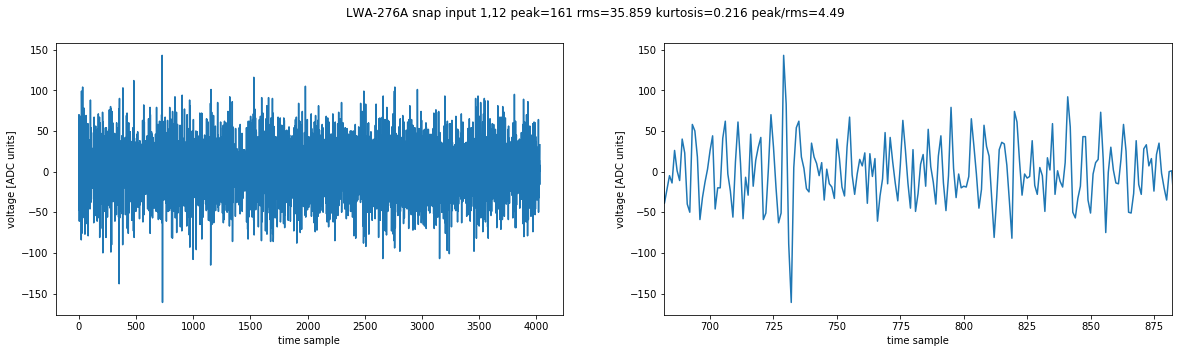

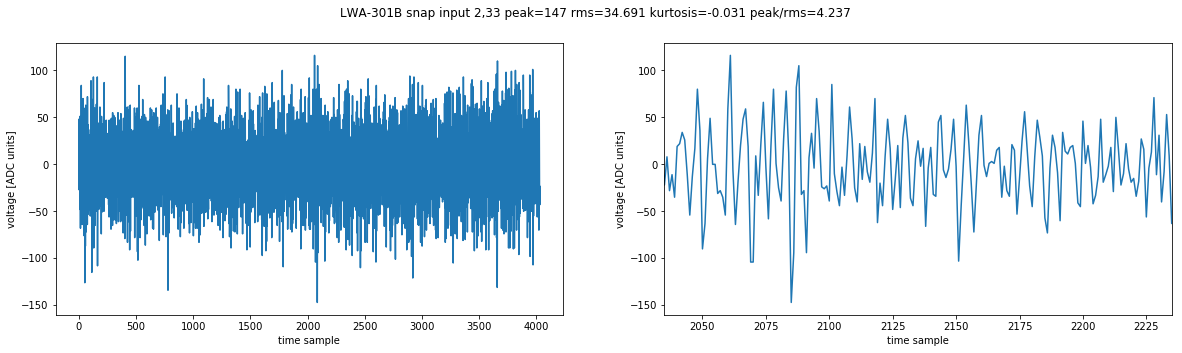

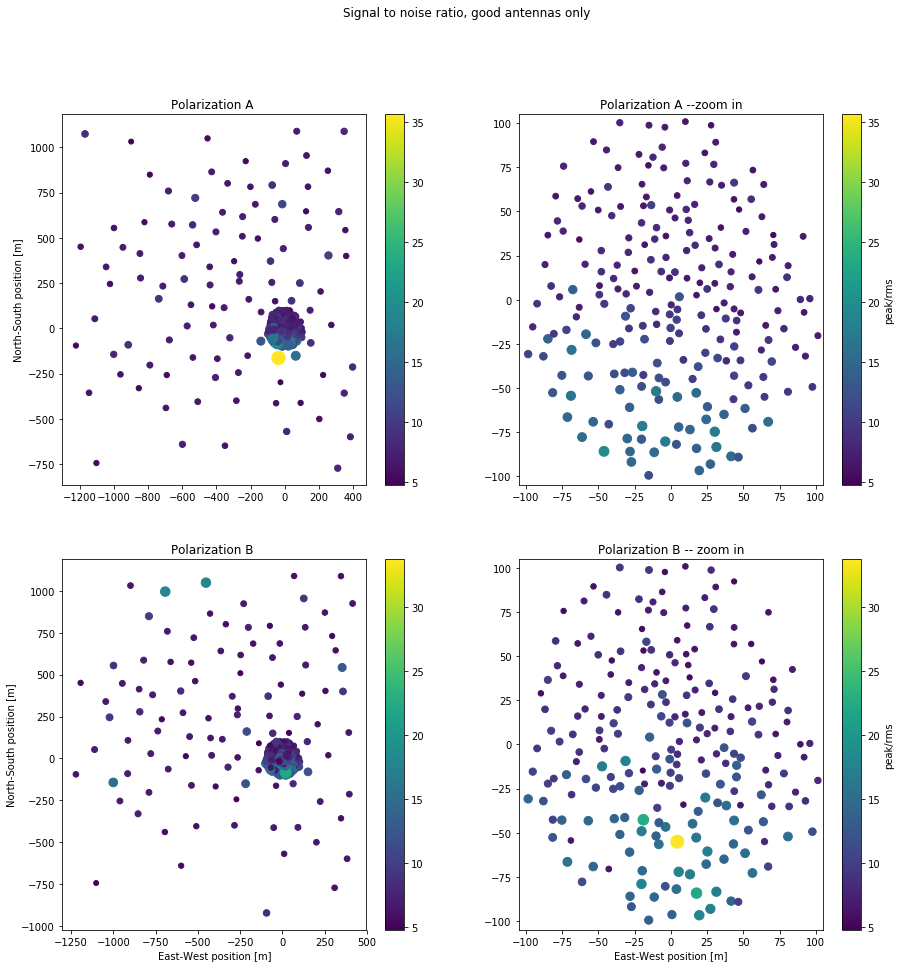

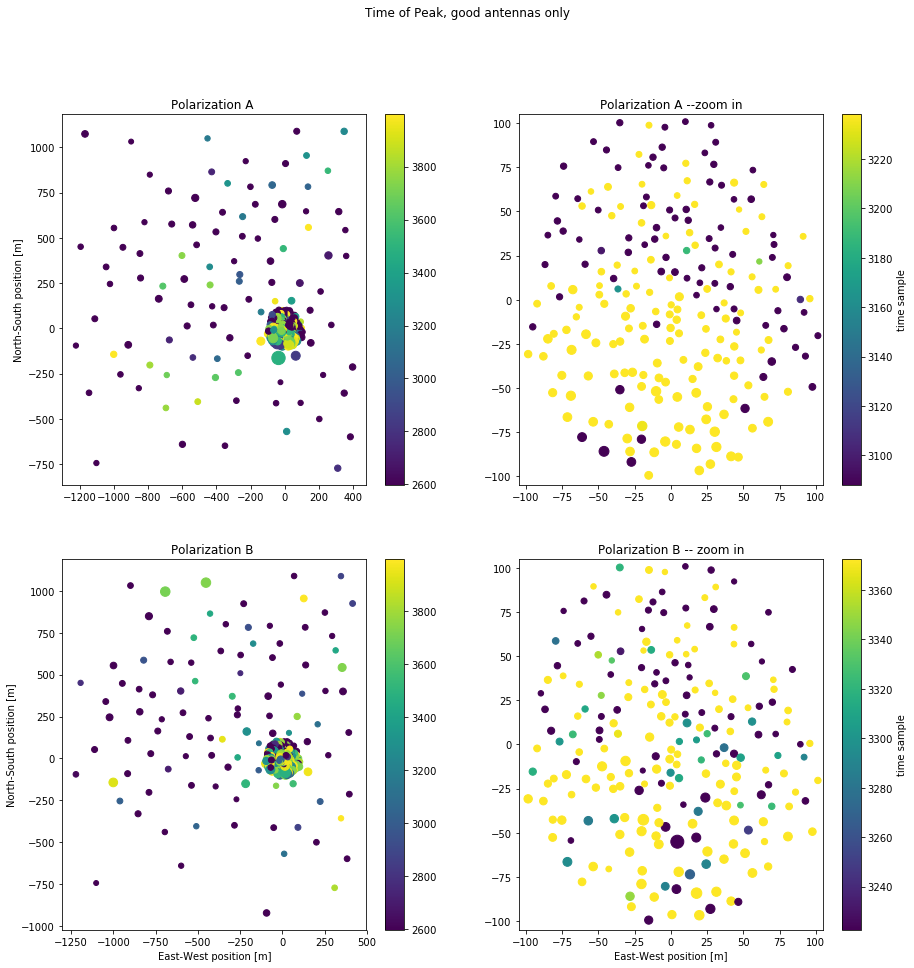

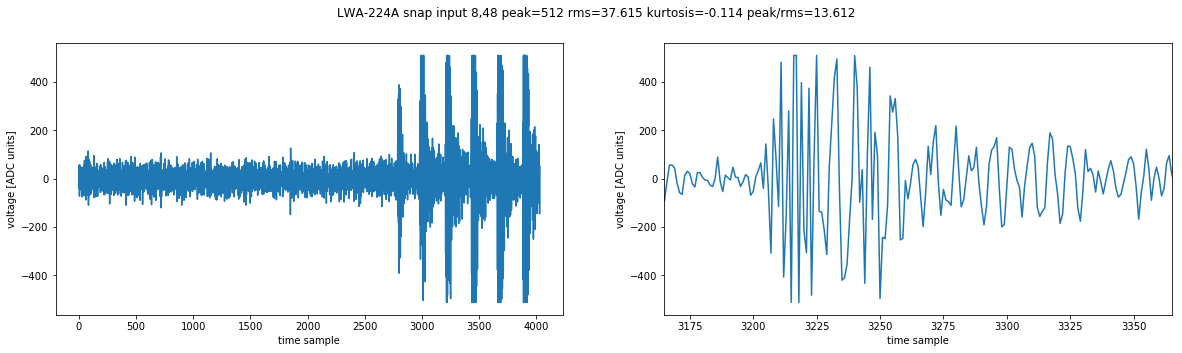

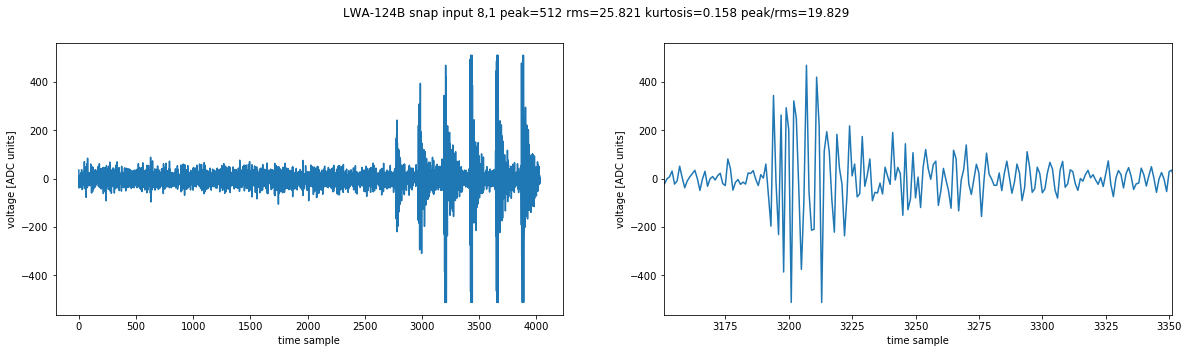

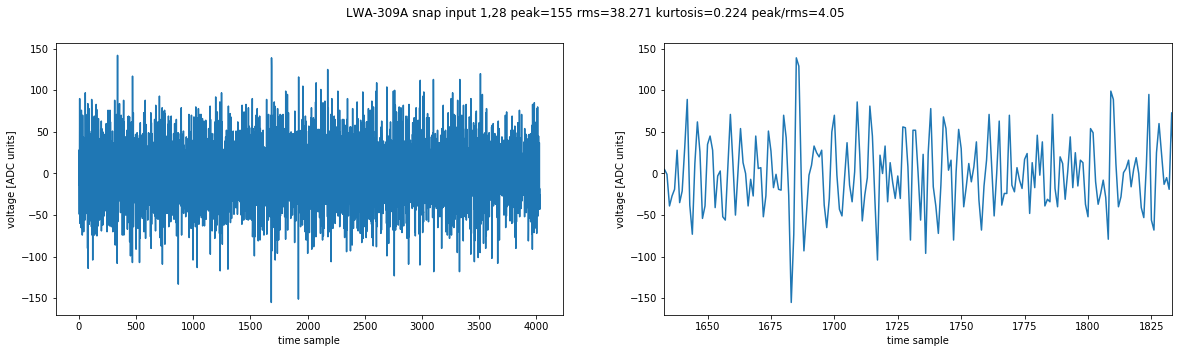

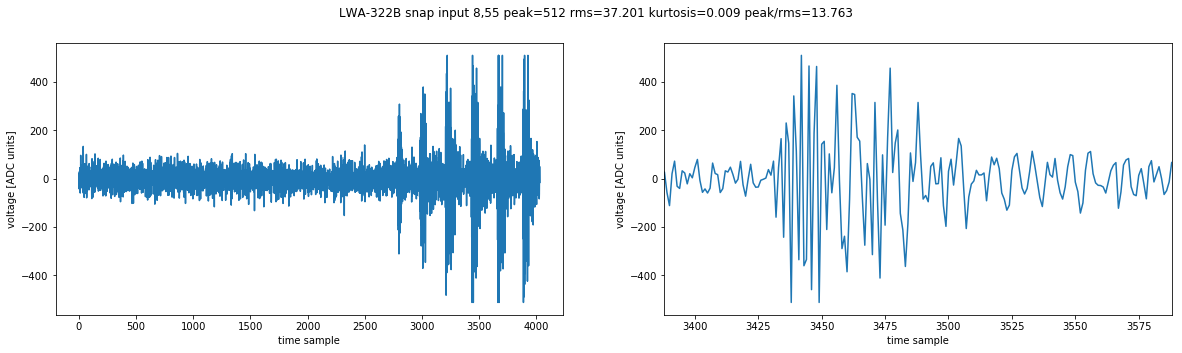

1 42255.2693527.dat


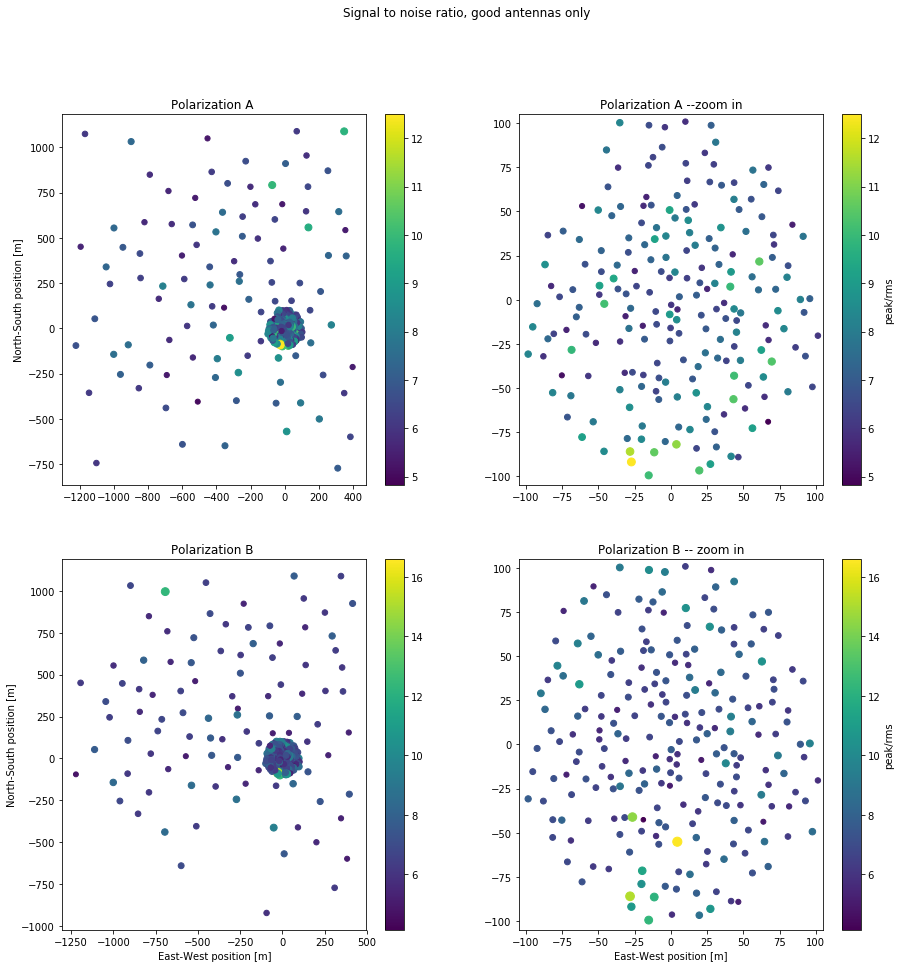

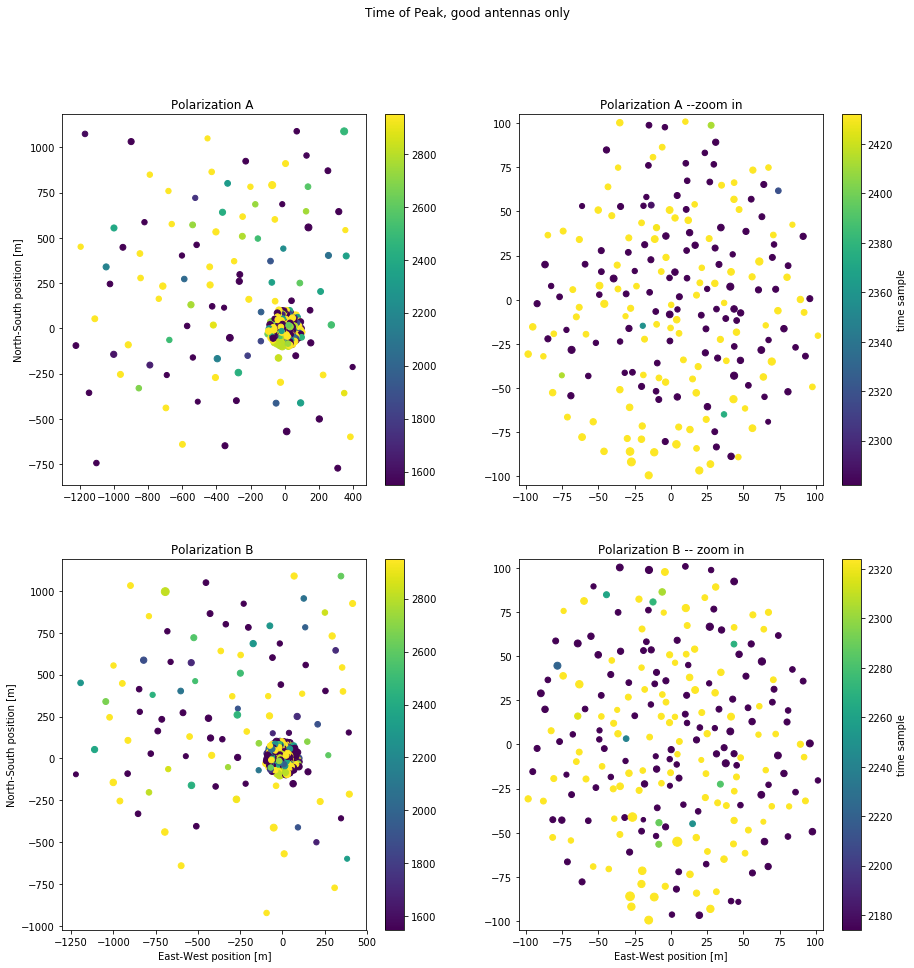

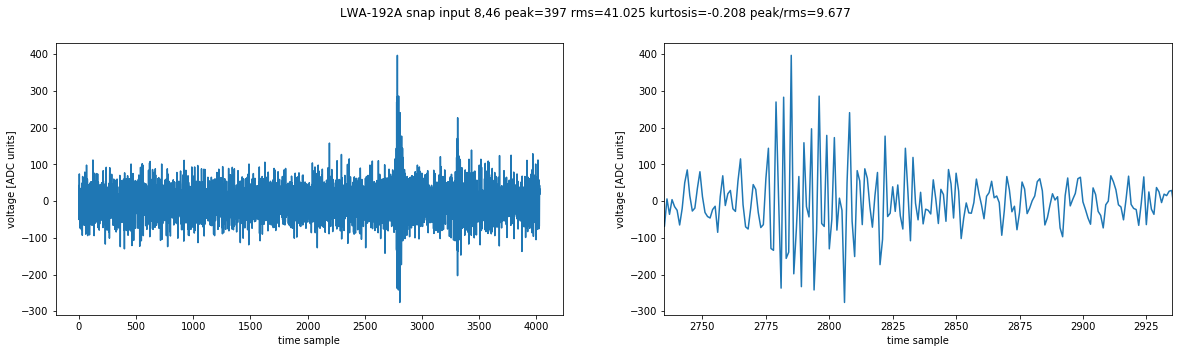

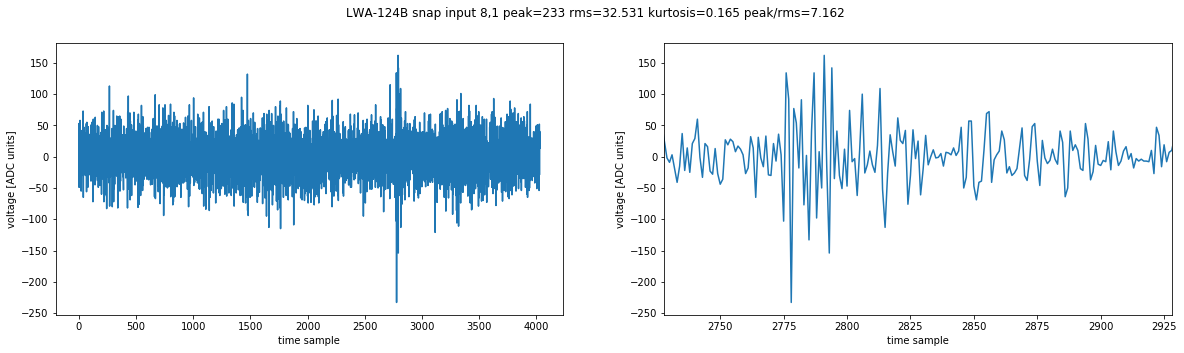

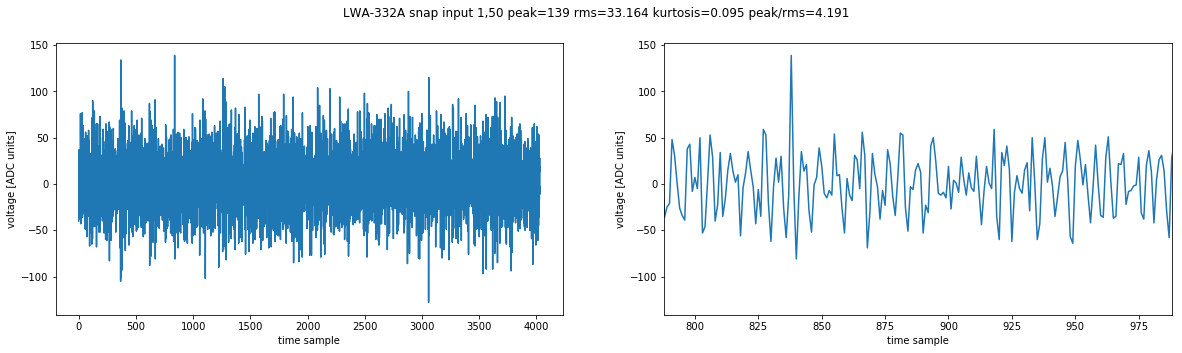

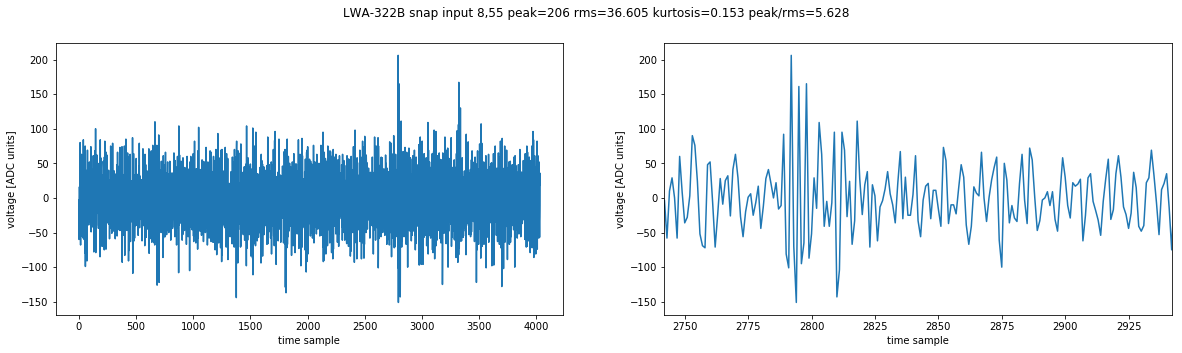

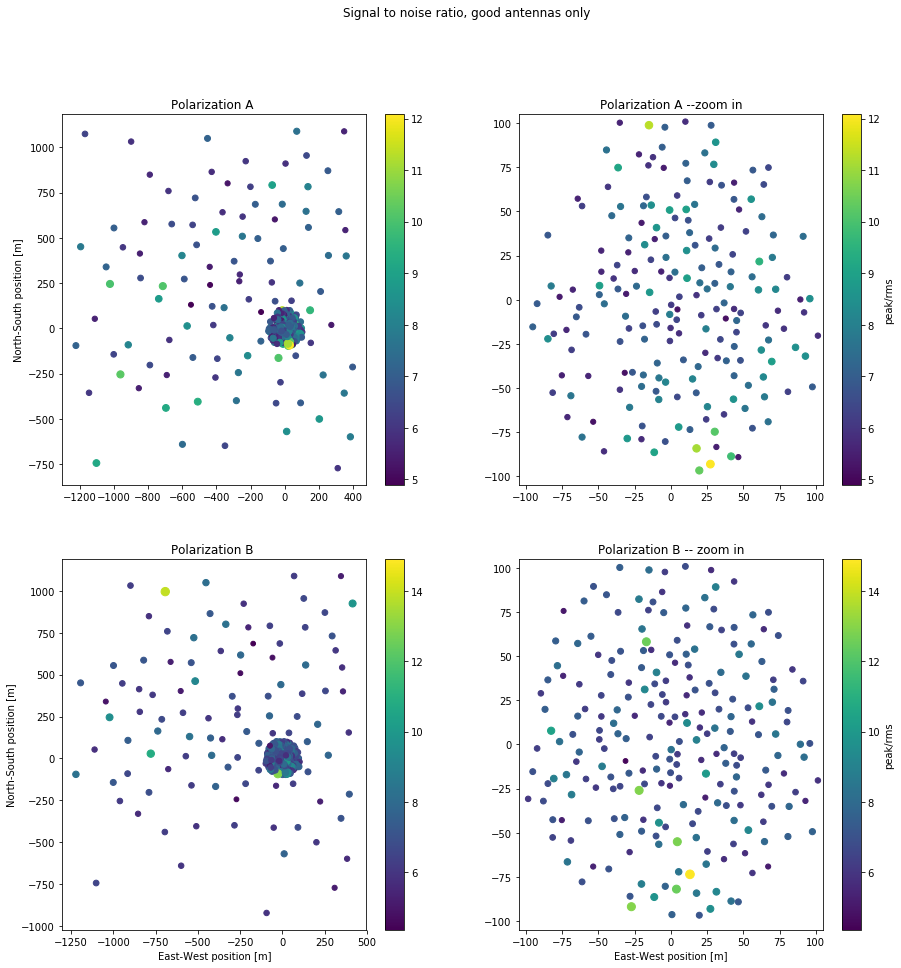

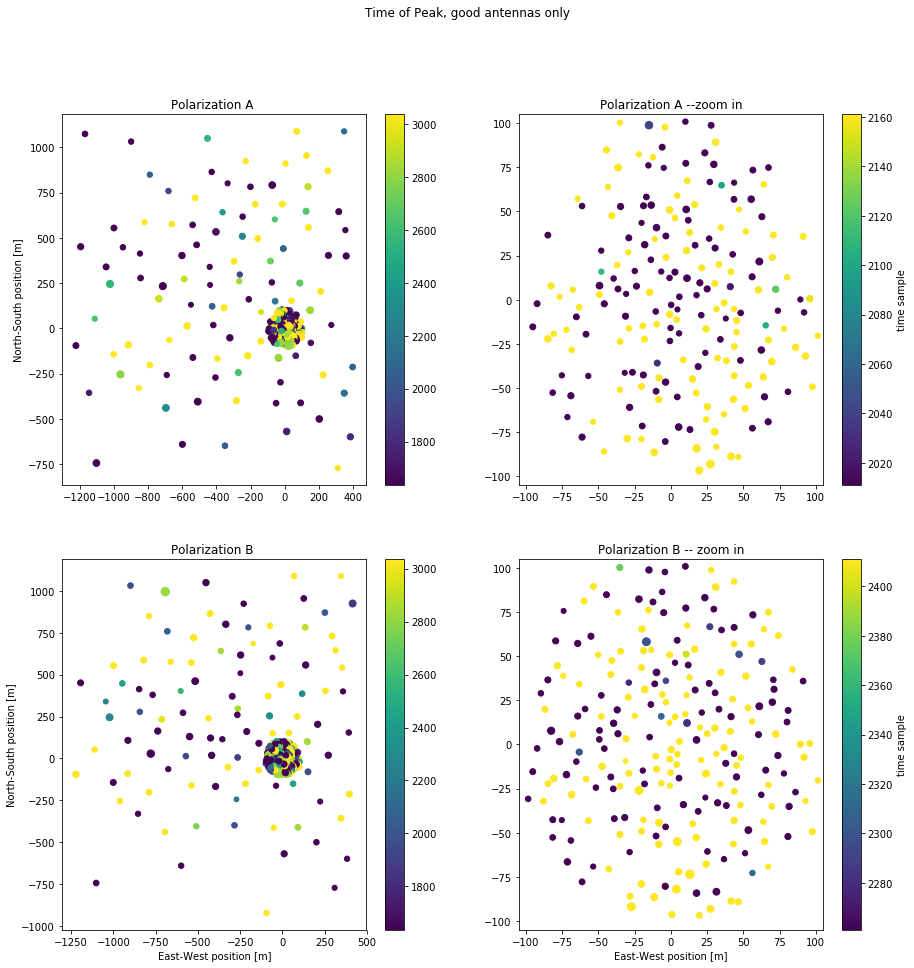

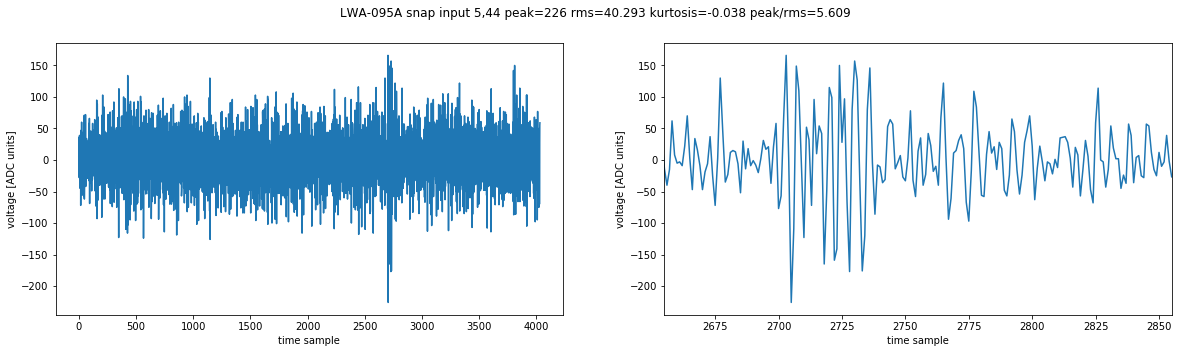

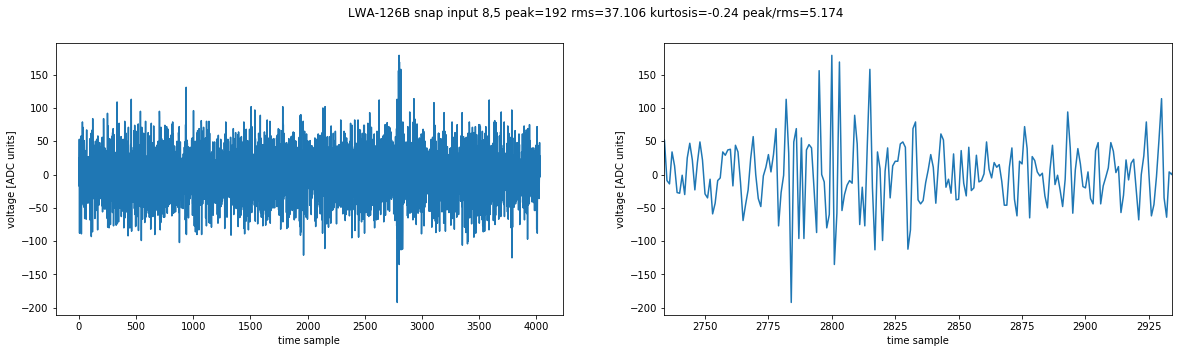

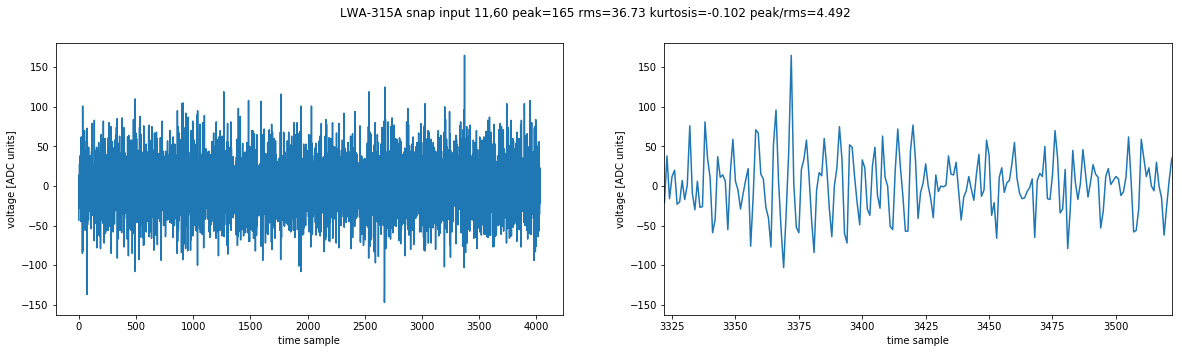

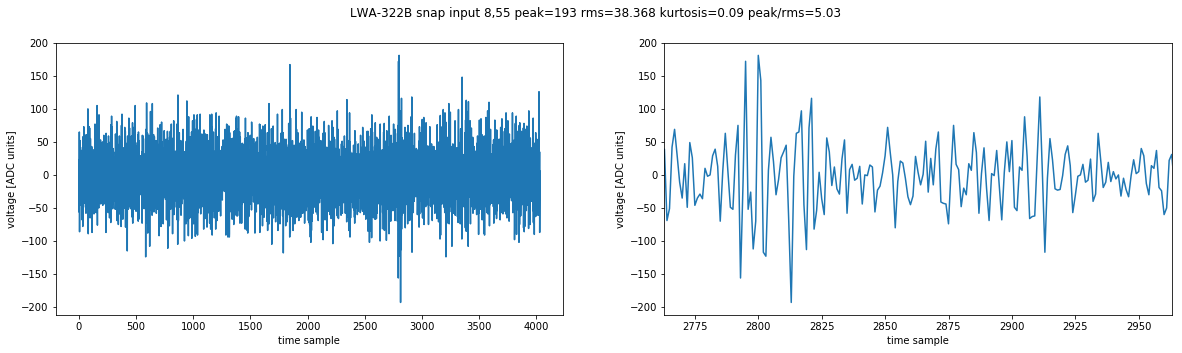

In [70]:


##load arraymap
array_map=pd.read_csv('array-map-5-22-2023.csv')
xdict={}
ydict={}
zdict={}
for i,n in enumerate(array_map['antname']):
    xdict[n]=array_map['x'][i]
    ydict[n]=array_map['y'][i]
    zdict[n]=array_map['elevation'][i]
arraymapdictionaries=[xdict,ydict,zdict]

for f,datafname in enumerate(files_with_interesting_events[9:11]):
    print(f, datafname)
    saved_events_indices=np.load(dataproductsdir+datafname[:-3]+'indices_cuts1.npy')
    for i in saved_events_indices:
        event_records=parsefile(datadir+datafname,start_ind=i,end_ind=704 )
        merged=mergepolarizations(event_records,arraymapdictionaries)
        #print(sum(['rmsB' in m.keys() for m in merged]))
        
        plot_event_snr(event_records,arraymapdictionaries,minimum_ok_rms=25,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=False)
        plot_event_toas(event_records,arraymapdictionaries,minimum_ok_rms=25,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=False)

        coreA,coreB,farA,farB=rank_by_snr(event_records,arraymapdictionaries)
        nplot=1
        for rankedlist in coreA,coreB,farA,farB:
            if len(rankedlist)>nplot:
                plot_timeseries(event_records,[A[1] for A in rankedlist[:nplot]],zoom='peak')
            else:
                plot_timeseries(event_records,[A[1] for A in rankedlist],zoom='peak')
        plt.show()

## Functions and further inspection-- can I delete this?

In [35]:
def plot_event_toas(event,arraymapdictionaries,minimum_ok_rms=25,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=False,Filter='None'):
    #Plots the time of arrival for each antenna and polarization of an event, over the antenna positions of the array
    #time of arrival is in units of clock cycles with respect to the earliest packet timestamp in the event
    #Event is a list of records (single-packet dictionaries) belonging to the same event
    #Antennas are filtered to only plot antennas whose signals (in the first half of the buffer) are within the
    #bounds set by minimum_ok_rms, maximum_ok_rms, minimum_ok_kurtosis, maximum_ok_kurtosis
    #Antennas are labelled if annotate=True
    #Filter can be None or a 1D numpy array of coefficients for a time-domain FIR. If filter is not none, the timeseries will be convolved with the provided coefficients.
    
    mergedrecords=mergepolarizations(event,arraymapdictionaries,Filter)

    xcoords=np.asarray([record['x'] for record in mergedrecords])
    ycoords=np.asarray([record['y'] for record in mergedrecords])
    zcoords=np.asarray([record['z'] for record in mergedrecords])
    antnames=[record['antname'] for record in mergedrecords]
    #get rms 
    rmsA=np.asarray([(record['meansmoothedA'])**0.5 for record in mergedrecords])
    rmsB=np.asarray([(record['meansmoothedB'])**0.5 for record in mergedrecords])

    peakA=np.asarray([record['peaksmoothedA'] for record in mergedrecords])
    peakB=np.asarray([record['peaksmoothedB'] for record in mergedrecords])

    snrA=peakA/(rmsA**2)
    snrB=peakB/(rmsB**2)
    
    #get time of peak
    index_peak_A=np.asarray([record['index_peak_A'] for record in mergedrecords])
    index_peak_B=np.asarray([record['index_peak_B'] for record in mergedrecords])
    timestamps=np.asarray([record['timestamp'] for record in mergedrecords])
    min_time=np.min(timestamps)

    t_rel_A=index_peak_A + timestamps - min_time
    t_rel_B=index_peak_B + timestamps - min_time
    
    
    #get kurtosis before event
    kurtosisA=np.asarray([record['kurtosisA'] for record in mergedrecords])
    kurtosisB=np.asarray([record['kurtosisB'] for record in mergedrecords])

    #define antenna cut based on rms 
    cut_rmsA = np.logical_and(rmsA >minimum_ok_rms, rmsA <maximum_ok_rms)
    cut_rmsB = np.logical_and(rmsB >minimum_ok_rms, rmsB <maximum_ok_rms)
    
    #define antenna cut based on kurtosis
    cut_kurtosisA = np.logical_and(kurtosisA >minimum_ok_kurtosis, kurtosisA <maximum_ok_kurtosis)
    cut_kurtosisB = np.logical_and(kurtosisB >minimum_ok_kurtosis, kurtosisB <maximum_ok_kurtosis)

    #combine antenna cuts
    cutA=np.logical_and(cut_rmsA,cut_kurtosisA)
    cutB=np.logical_and(cut_rmsB,cut_kurtosisB)

    
    select_core_antennas=(xcoords**2)+(ycoords**2)<(115**2)
    select_far_antennas=(xcoords**2)+(ycoords**2)>(115**2)  #note the core vs far cuts used in plotting are different than what's used for estimating if event is concentrated on core
    
    sizescale=5
    plt.figure(figsize=(15,15))
    plt.suptitle('Time of Peak, good antennas only')
    plt.subplot(221)
    plt.title("Polarization A ")
    plt.scatter(xcoords[cutA],ycoords[cutA],c=t_rel_A[cutA],s=sizescale*(snrA[cutA]))
    plt.colorbar()
    plt.clim(np.median(t_rel_B[cutB])-700,np.median(t_rel_B[cutB])+700)
    plt.ylabel('North-South position [m]')
    if annotate:
        for i in range(len(antnames)):
            if cutA[i] and select_far_antennas[i]:
                txt=antnames[i]
                x=xcoords[i]
                y=ycoords[i]
                plt.annotate(txt[3:], (x, y))
    
    plt.subplot(222)
    plt.title("Polarization A --zoom in")
    plt.scatter(xcoords[cutA],ycoords[cutA],c=t_rel_A[cutA],s=sizescale*(snrA[cutA]))
    plt.xlim(-105,105)
    plt.ylim(-105,105)
    plt.colorbar(label='time sample')
    plt.clim(np.median(t_rel_A[cutA])-75,np.median(t_rel_A[cutA])+75)
    if annotate:
        for i in range(len(antnames)):
            if cutA[i] and select_core_antennas[i]:
                txt=antnames[i]
                x=xcoords[i]
                y=ycoords[i]
                plt.text(x,y,txt[3:],fontsize='x-small')
                
    plt.subplot(223)
    plt.title("Polarization B ")
    plt.scatter(xcoords[cutB],ycoords[cutB],c=t_rel_B[cutB],s=sizescale*(snrB[cutB]))
    plt.colorbar()
    plt.clim(np.median(t_rel_B[cutB])-700,np.median(t_rel_B[cutB])+700)

    plt.xlabel('East-West position [m]')
    plt.ylabel('North-South position [m]')
    if annotate:
        for i in range(len(antnames)):
            if cutB[i] and select_far_antennas[i]:
                txt=antnames[i]
                x=xcoords[i]
                y=ycoords[i]
                plt.annotate(txt[3:], (x, y))

    plt.subplot(224)
    plt.title("Polarization B -- zoom in")
    plt.scatter(xcoords[cutB],ycoords[cutB],c=t_rel_B[cutB],s=sizescale*(snrB[cutB]))
    plt.xlim(-105,105)
    plt.ylim(-105,105)
    plt.colorbar(label='time sample')
    plt.clim(np.median(t_rel_B[cutB])-75,np.median(t_rel_B[cutB])+75)
    plt.xlabel('East-West position [m]')
    
    if annotate:
        for i in range(len(antnames)):
            if cutB[i] and select_core_antennas[i]:
                txt=antnames[i]
                x=xcoords[i]
                y=ycoords[i]
                plt.text(x,y,txt[3:],fontsize='x-small')
    return



In [36]:
def plot_event_snr(event,arraymapdictionaries,minimum_ok_rms=25,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=False,Filter='None'):
    #Plots the snr for each polarization of an event, over the antenna positions of the array
    #snr is defined as peak of smoothed power divided by mean smoothed power
    #Event is a list of records (single-packet dictionaries) belonging to the same event
    #Antennas are filtered to only plot antennas whose signals (in the first half of the buffer) are within the
    #bounds set by minimum_ok_rms, maximum_ok_rms, minimum_ok_kurtosis, maximum_ok_kurtosis
    #Antennas are labelled if annotate=True
    #Filter can be None or a 1D numpy array of coefficients for a time-domain FIR. If filter is not none, the timeseries will be convolved with the provided coefficients during the mergepolarizations function.
    mergedrecords=mergepolarizations(event,arraymapdictionaries,Filter)

    xcoords=np.asarray([record['x'] for record in mergedrecords])
    ycoords=np.asarray([record['y'] for record in mergedrecords])
    zcoords=np.asarray([record['z'] for record in mergedrecords])
    antnames=[record['antname'] for record in mergedrecords]

    #get snr ratio
    noiseA=np.asarray([record['meansmoothedA'] for record in mergedrecords])
    peakA=np.asarray([record['peaksmoothedA'] for record in mergedrecords])
    noiseB=np.asarray([record['meansmoothedB'] for record in mergedrecords])
    peakB=np.asarray([record['peaksmoothedB'] for record in mergedrecords])

    snrA=peakA/noiseA
    snrB=peakB/noiseB
    
    #get kurtosis before event
    kurtosisA=np.asarray([record['kurtosisA'] for record in mergedrecords])
    kurtosisB=np.asarray([record['kurtosisB'] for record in mergedrecords])

    #define antenna cut based on rms 
    cut_rmsA = np.logical_and(noiseA >minimum_ok_rms**2, noiseA <maximum_ok_rms**2)
    cut_rmsB = np.logical_and(noiseB >minimum_ok_rms**2, noiseB <maximum_ok_rms**2)
    
    #define antenna cut based on kurtosis
    cut_kurtosisA = np.logical_and(kurtosisA >minimum_ok_kurtosis, kurtosisA <maximum_ok_kurtosis)
    cut_kurtosisB = np.logical_and(kurtosisB >minimum_ok_kurtosis, kurtosisB <maximum_ok_kurtosis)

    #combine antenna cuts
    cutA=np.logical_and(cut_rmsA,cut_kurtosisA)
    cutB=np.logical_and(cut_rmsB,cut_kurtosisB)
    
    select_core_antennas=(xcoords**2)+(ycoords**2)<(115**2)
    select_far_antennas=(xcoords**2)+(ycoords**2)>(115**2)  #note the core vs far cuts used in plotting are different than what's used for estimating if event is concentrated on core
    
    sizescale=5
    plt.figure(figsize=(15,15))
    plt.suptitle('Signal to noise ratio, good antennas only')
    plt.subplot(221)
    plt.title("Polarization A ")
    plt.scatter(xcoords[cutA],ycoords[cutA],c=snrA[cutA],s=sizescale*(snrA[cutA]))
    plt.colorbar()
    plt.ylabel('North-South position [m]')
    if annotate:
        for i in range(len(antnames)):
            if cutA[i] and select_far_antennas[i]:
                txt=antnames[i]
                x=xcoords[i]
                y=ycoords[i]
                plt.annotate(txt[3:], (x, y))
    
    plt.subplot(222)
    plt.title("Polarization A --zoom in")
    plt.scatter(xcoords[cutA],ycoords[cutA],c=snrA[cutA],s=sizescale*(snrA[cutA]))
    plt.xlim(-105,105)
    plt.ylim(-105,105)
    plt.colorbar(label='peak/rms')
    #plt.clim(cmin,cmax)
    if annotate:
        for i in range(len(antnames)):
            if cutA[i] and select_core_antennas[i]:
                txt=antnames[i]
                x=xcoords[i]
                y=ycoords[i]
                plt.text(x,y,txt[3:],fontsize='x-small')
                
    plt.subplot(223)
    plt.title("Polarization B ")
    plt.scatter(xcoords[cutB],ycoords[cutB],c=snrB[cutB],s=sizescale*(snrB[cutB]))
    plt.colorbar()
    plt.xlabel('East-West position [m]')
    plt.ylabel('North-South position [m]')
    if annotate:
        for i in range(len(antnames)):
            if cutB[i] and select_far_antennas[i]:
                txt=antnames[i]
                x=xcoords[i]
                y=ycoords[i]
                plt.annotate(txt[3:], (x, y))

    plt.subplot(224)
    plt.title("Polarization B -- zoom in")
    plt.scatter(xcoords[cutB],ycoords[cutB],c=snrB[cutB],s=sizescale*(snrB[cutB]))
    plt.xlim(-105,105)
    plt.ylim(-105,105)
    plt.colorbar(label='peak/rms')
    plt.xlabel('East-West position [m]')
    
    if annotate:
        for i in range(len(antnames)):
            if cutB[i] and select_core_antennas[i]:
                txt=antnames[i]
                x=xcoords[i]
                y=ycoords[i]
                plt.text(x,y,txt[3:],fontsize='x-small')

    return